# **1. CIFAR10 Competition model**

Model for the inclass competition in Neural Networks and Learnign System course at Linköping Univerity, spring 2022.

The competition allows for only training for 50 epochs. Here we present our model when running for 50 epochs but also for XXX epochs

### **1. Setup of enviroment and loading the dataset**

In [1]:
# Library imports
import os
import tensorflow as tf
import numpy as np
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Flatten, Conv2D, MaxPooling2D, Dropout, BatchNormalization, Activation, Add, AveragePooling2D, ZeroPadding2D, MaxPool2D, concatenate, LocallyConnected2D
from tensorflow.keras.utils import plot_model, to_categorical
from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.initializers import GlorotNormal
from tensorflow.keras.activations import swish
from Custom import PlotModelEval


# Set-up CUDA enviroment
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"

# This sets the GPU to allocate memory only as needed
physical_devices = tf.config.experimental.list_physical_devices('GPU')
if len(physical_devices) != 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True) 

2022-02-27 18:27:20.582265: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2022-02-27 18:27:21.743903: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-02-27 18:27:21.744299: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-02-27 18:27:21.782694: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-27 18:27:21.782901: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce RTX 2080 SUPER computeCapability: 7.5
coreClock: 1.815GHz coreCount: 48 deviceMemorySize: 7.77GiB deviceMemoryBandwidth: 462.00GiB/s
2022-02-27 18:27:21.782911: I tensorflow/stream_executor/platf

In [2]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

print("Shape of training data:")
print(X_train.shape)
print(y_train.shape)
print("Shape of test data:")
print(X_test.shape)
print(y_test.shape)

Shape of training data:
(50000, 32, 32, 3)
(50000, 1)
Shape of test data:
(10000, 32, 32, 3)
(10000, 1)


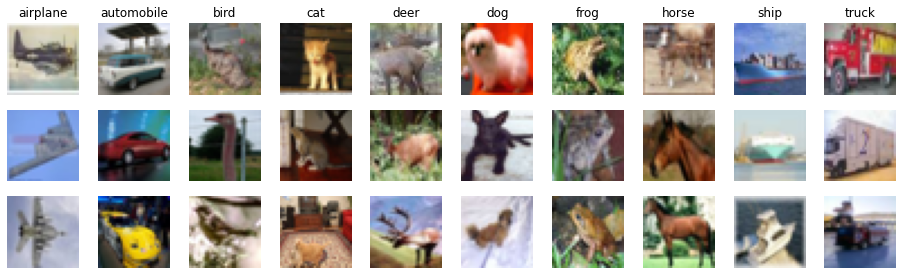

In [3]:
from Custom import PlotRandomFromEachClass

cifar_labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
PlotRandomFromEachClass(X_train, y_train, 3, labels=cifar_labels)

In [4]:
# Transform label indices to one-hot encoded vectors
y_train_c = to_categorical(y_train, num_classes=10)
y_test_c  = to_categorical(y_test , num_classes=10)

# Normalization of pixel values (to [0-1] range)
X_train = X_train.astype('float32') / 255
X_test  = X_test.astype('float32')  / 255

### **2. Creating the blocks**

We were inspired by the GoogleNet structure but made some changes to the architecture. We use regular convolutional blocks, inception blocks and downsampling blocks. We also implement polynomial decay of the learning rate.

In [5]:
# Set initializer to Xavier normal
xav_initializer = GlorotNormal()

## Data augmentation
aug = ImageDataGenerator(width_shift_range = 0.1, height_shift_range = 0.1, horizontal_flip = True, fill_mode = "nearest", validation_split = 0.05)

aug_train = aug.flow(X_train, y_train_c, batch_size = 64, subset = "training")
aug_vali = aug.flow(X_train, y_train_c, batch_size = 64, subset = "validation")

def convolutional_block(x, n_filters ,filter_sizeX, filter_sizeY, stride, axises, padding = "same"):
    """Basic convolutional block; with 2D convolution, then batch normalization and finally activating with relu"""
    x = Conv2D(n_filters,(filter_sizeX, filter_sizeY), strides=stride, padding=padding, kernel_initializer = xav_initializer)(x)
    x = BatchNormalization(axis = axises)(x)
    x = Activation("swish")(x)
    return x

def inception_block(x, conv1_size, conv2_size, conv5_size, n_pooling, axises):
    """Three separate convolutional blocks (1x1, 3x3 and 5x5) and a block of maxpooling followed by a convolution. 
    Return the concatenation of the three convolutional blocks and a maxpooling """
    conv_1 = convolutional_block(x, conv1_size, 1, 1,(1, 1), axises) 
    conv_3 = convolutional_block(x, conv2_size, 3, 3,(1, 1), axises)
    conv_5 = convolutional_block(x, conv5_size, 5, 5,(1, 1), axises)
        
    pooled = MaxPooling2D((3, 3), strides=(1, 1), padding = "same")(x)
    pooled = Conv2D(n_pooling, (1, 1), padding = "same", activation = "swish", kernel_initializer = xav_initializer)(pooled)
    
    x = concatenate([conv_1, conv_3, conv_5, pooled], axis=axises)
    return x

def downsample_block(x, n_filters, axises):
    """For a given input runs one convolutional block, and a pooling of input then put together"""
    conv_3 = convolutional_block(x, n_filters,3,3,(2,2), axises, padding = "valid")
    pool = MaxPooling2D((3,3),strides=(2,2))(x)
    x = concatenate([conv_3,pool],axis = axises)
    return x

init_lr = 5e-3

def polynomial_decay(epoch):
    """Function to allow for polynomial decay of the learning rate"""
    maxEpochs = n_epochs
    baseLR = init_lr
    alpha = baseLR * (1 - (epoch / float(maxEpochs)))
    return alpha

In [13]:
GroupName = "AI4Good"

x_in = Input(shape=X_train.shape[1:])

# convolutional module followed by two inception modules
x = convolutional_block(x_in, n_filters = 96, filter_sizeX = 3, filter_sizeY = 3, stride = (1, 1), axises = -1)
x = inception_block(x, conv1_size = 32, conv2_size = 32, conv5_size = 32, n_pooling = 32, axises = -1)
x_split1 = inception_block(x, conv1_size = 32, conv2_size = 48, conv5_size = 48, n_pooling = 32, axises = -1)

# Three disconnected downsample modules 
x = downsample_block(x_split1, n_filters = 80, axises = -1)
x1 = downsample_block(x_split1, n_filters = 80, axises = -1)
x2 = downsample_block(x_split1, n_filters = 80, axises = -1)

# Followed by two inception modules for each disconnected path
x = inception_block(x, conv1_size = 112, conv2_size = 48, conv5_size = 32, n_pooling = 48, axises = -1)
x = inception_block(x, conv1_size = 96, conv2_size = 64, conv5_size = 32, n_pooling = 32, axises = -1) # Output (15,15, 224)

x1 = inception_block(x1, conv1_size = 112, conv2_size = 48, conv5_size = 32, n_pooling = 48, axises = -1)
x1 = inception_block(x1, conv1_size = 96, conv2_size = 64, conv5_size = 32, n_pooling = 32, axises = -1) # Output (15,15,224)

x2 = inception_block(x2, conv1_size = 112, conv2_size = 48, conv5_size = 32, n_pooling = 48, axises = -1)
x2 = inception_block(x2, conv1_size = 96, conv2_size = 64, conv5_size = 32, n_pooling = 32, axises = -1) # Output (15,15,224)

# Concatenate left and center paths and followed by a convolutional module
x_partial1 = concatenate([x,x1], axis = -1)
x_partial1 = convolutional_block(x_partial1, n_filters = 336, filter_sizeX = 3, filter_sizeY=3, stride = (1,1), axises = -1)
# Concatenate right and center paths and followed by a convolutional module
x_partial2 = concatenate([x1,x2], axis = -1)
x_partial2 = convolutional_block(x_partial2, n_filters = 336, filter_sizeX = 3, filter_sizeY=3, stride = (1,1), axises = -1)

# Concatenate the whole network followed by two convolutional blocks
x_split2 = concatenate([x_partial1, x_partial2], axis = -1) # Output (15,15, 672)
x_split2 = convolutional_block(x_split2, n_filters = 336, filter_sizeX = 3, filter_sizeY=3, stride = (1,1), axises = -1)
x_split2 = convolutional_block(x_split2, n_filters = 224, filter_sizeX = 1, filter_sizeY=1, stride = (1,1), axises = -1)

# Split the network again into two disconnected paths by three inception modules each
x = inception_block(x_split2, conv1_size = 80, conv2_size = 80, conv5_size = 32, n_pooling = 32, axises = -1)
x1 = inception_block(x_split2, conv1_size = 80, conv2_size = 80, conv5_size = 32, n_pooling = 32, axises = -1)

x = inception_block(x, conv1_size = 48, conv2_size = 96, conv5_size = 32, n_pooling = 32, axises = -1)
x = inception_block(x, conv1_size = 112, conv2_size = 48, conv5_size = 32, n_pooling = 48, axises = -1)

x1 = inception_block(x1, conv1_size = 48, conv2_size = 96, conv5_size = 32, n_pooling = 32, axises = -1)
x1 = inception_block(x1, conv1_size = 112, conv2_size = 48, conv5_size = 32, n_pooling = 48, axises = -1)

# Downsample modules for both of the paths
x = downsample_block(x, n_filters = 96, axises = -1)
x1 = downsample_block(x1, n_filters = 96, axises = -1)

# Concatenate the network followed by two convolutional modules
x_split3 = concatenate([x,x1], axis = -1) # Ouput(7,7,372)
x_split3 = convolutional_block(x_split3, n_filters = 504, filter_sizeX = 3, filter_sizeY = 3, stride = (1,1), axises = -1)
x_split3 = convolutional_block(x_split3, n_filters = 336, filter_sizeX = 1, filter_sizeY = 1, stride = (1,1), axises = -1)

# Split the network again into two disconnected paths. Two inception modules each
x = inception_block(x_split3, conv1_size = 176, conv2_size = 160, conv5_size = 96, n_pooling = 96, axises = -1)
x = inception_block(x, conv1_size = 176, conv2_size = 160, conv5_size = 96, n_pooling = 96, axises = -1)

x1 = inception_block(x_split3, conv1_size = 176, conv2_size = 160, conv5_size = 96, n_pooling = 96, axises = -1)
x1 = inception_block(x1, conv1_size = 176, conv2_size = 160, conv5_size = 96, n_pooling = 96, axises = -1)

# Concatenate
x = concatenate([x,x1], axis = -1)

x = AveragePooling2D((7, 7))(x)
x = Dropout(0.5)(x)
x = Flatten()(x)
x = Dense(10)(x)
x = Activation("softmax")(x)

model = Model(inputs=x_in, outputs=x, name=GroupName)

In [14]:
callback = [LearningRateScheduler(polynomial_decay)]

opt = SGD(lr = init_lr, momentum = 0.9)
   
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer=opt)

Model: "AI4Good"
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_2 (InputLayer)             [(None, 32, 32, 3)]   0                                            
____________________________________________________________________________________________________
conv2d_84 (Conv2D)               (None, 32, 32, 96)    2688        input_2[0][0]                    
____________________________________________________________________________________________________
batch_normalization_66 (BatchNor (None, 32, 32, 96)    384         conv2d_84[0][0]                  
____________________________________________________________________________________________________
activation_67 (Activation)       (None, 32, 32, 96)    0           batch_normalization_66[0][0]     
__________________________________________________________________________

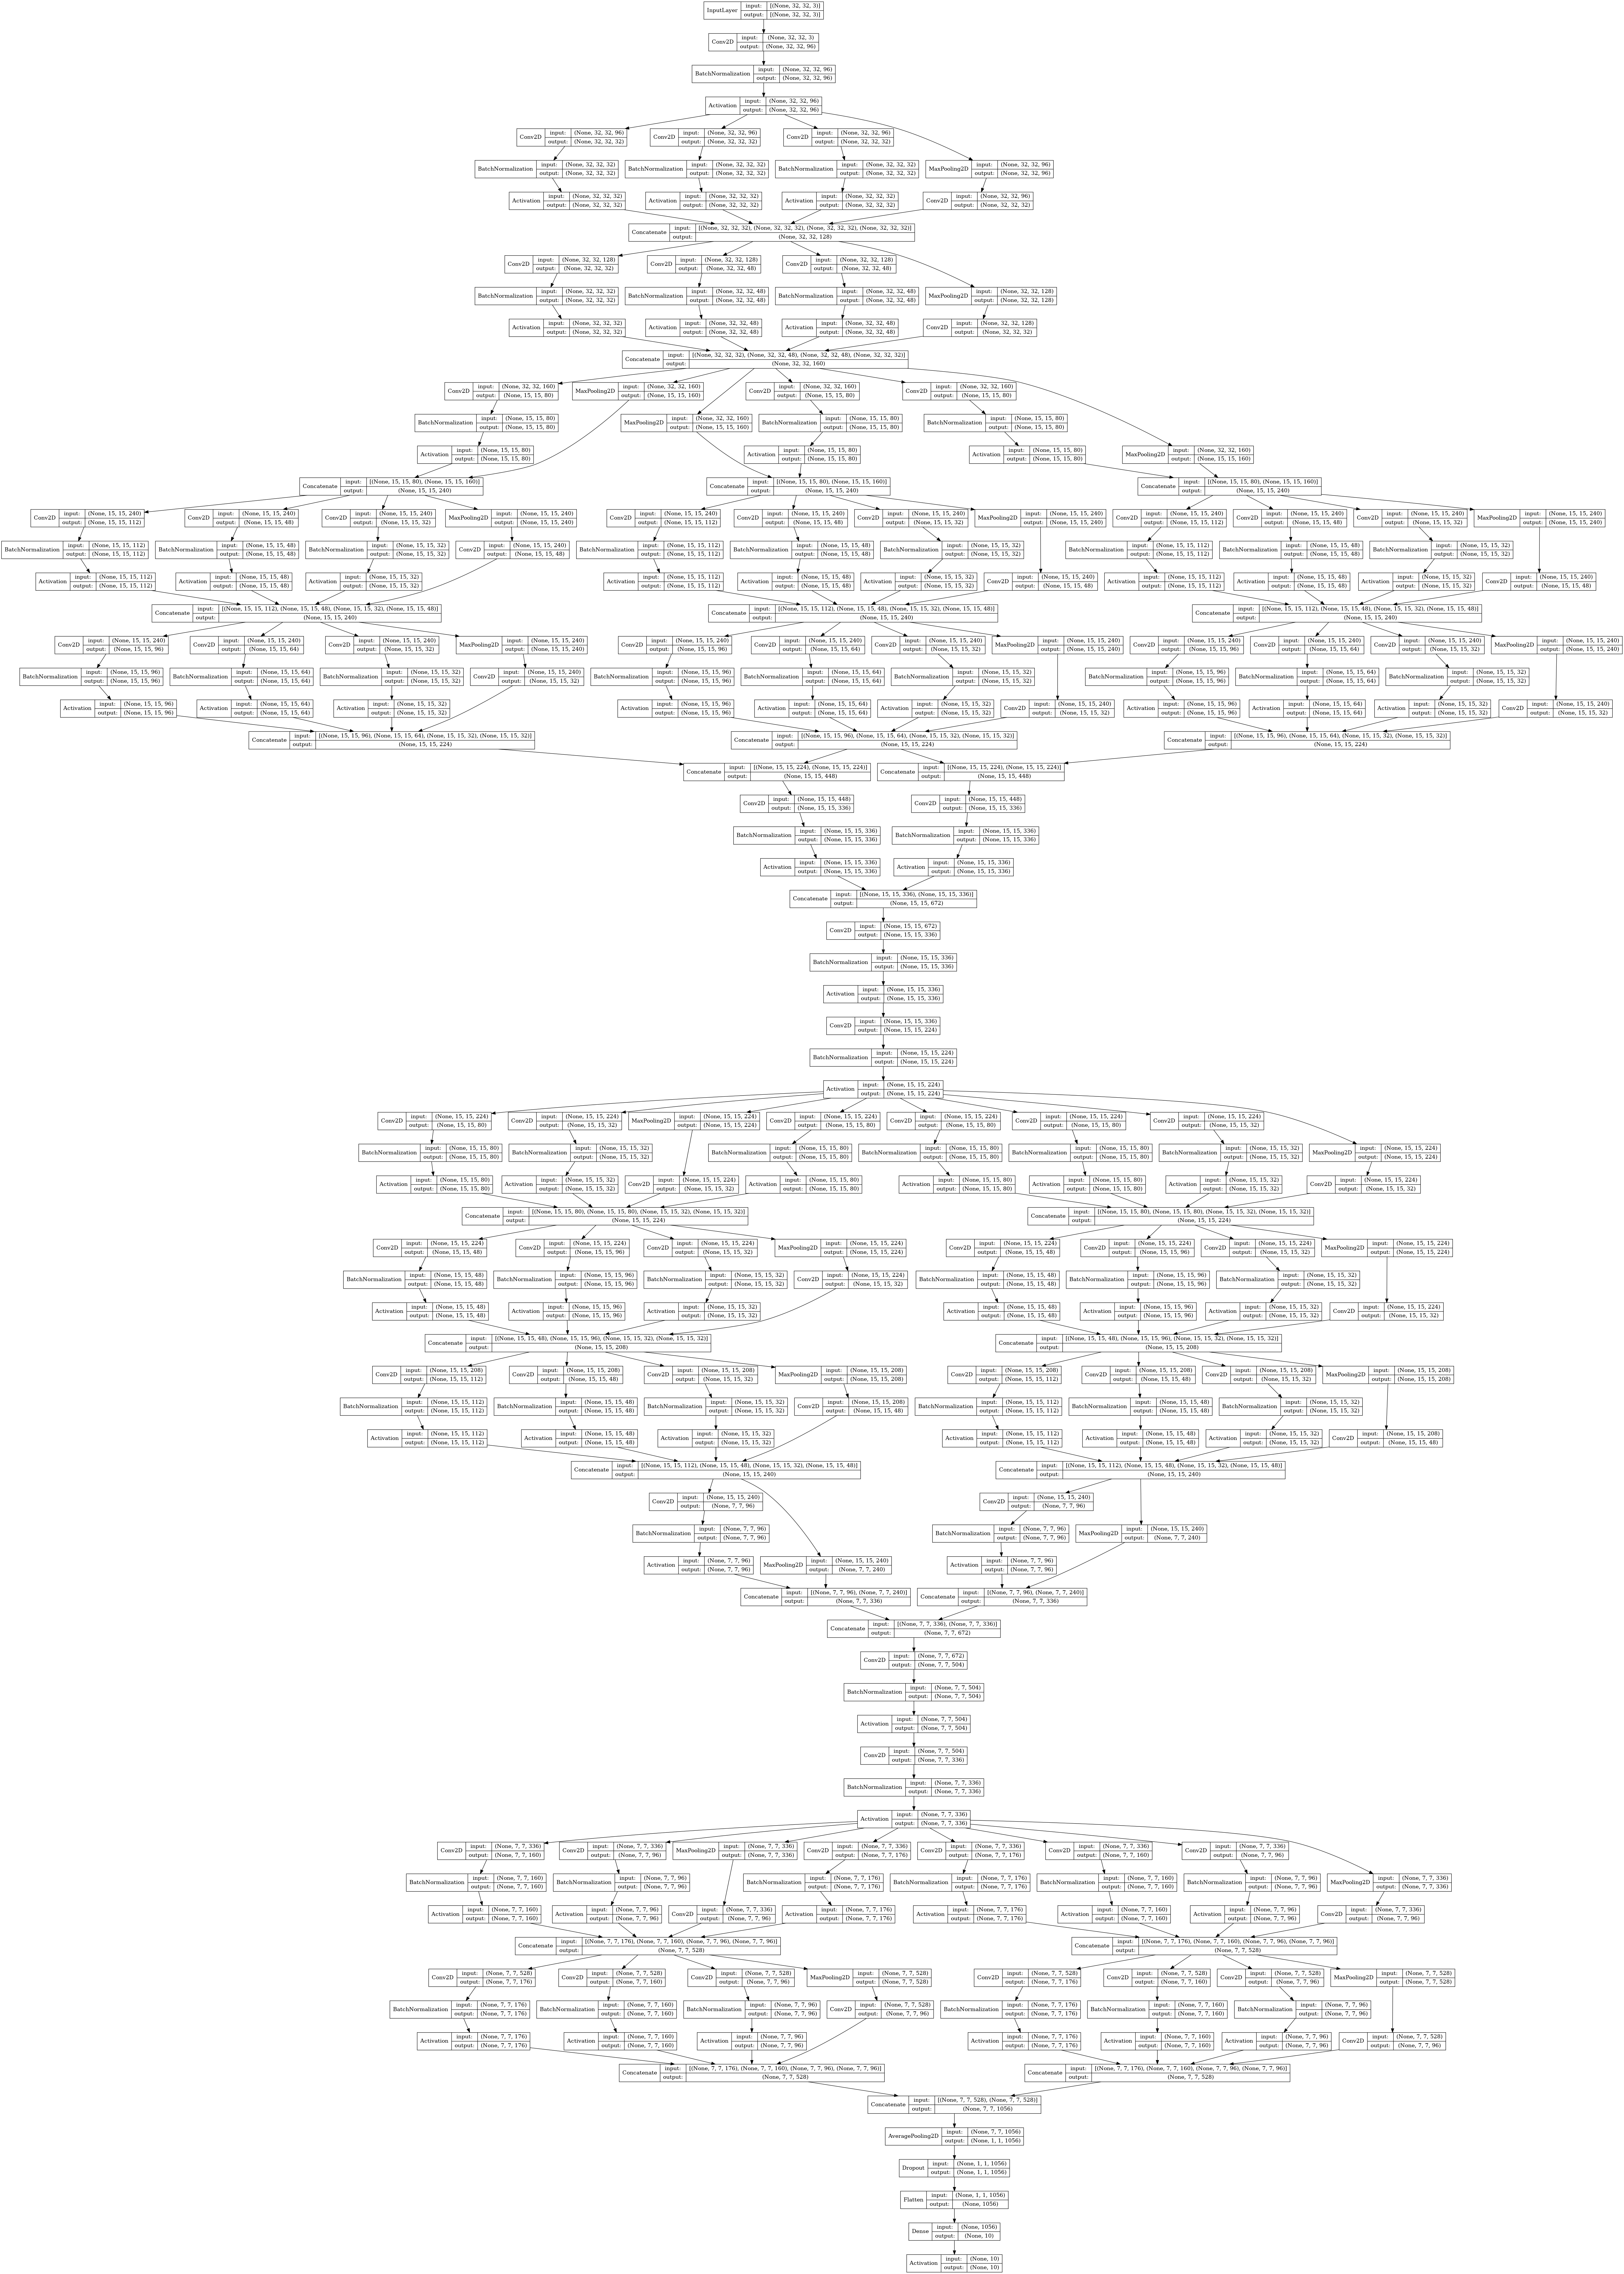

In [15]:
model.summary(100)
plot_model(model, show_shapes=True, show_layer_names=False)

In [9]:
n_epochs = 50
history = model.fit(aug_train, validation_data = aug_vali,
                    steps_per_epoch = (len(X_train)-2501) // 64, 
                    epochs = n_epochs, callbacks = callback,
                    verbose = 1)

2022-02-27 18:28:27.135554: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-02-27 18:28:27.153734: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 3699850000 Hz


Epoch 1/50


2022-02-27 18:28:31.584461: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2022-02-27 18:28:31.799669: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.7
2022-02-27 18:28:32.561879: W tensorflow/stream_executor/gpu/asm_compiler.cc:63] Running ptxas --version returned 256
2022-02-27 18:28:32.585608: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] Internal: ptxas exited with non-zero error code 256, output: 
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


742/742 [==============================] - 196s 217ms/step - loss: 1.6695 - accuracy: 0.3996 - val_loss: 1.0523 - val_accuracy: 0.6276
Epoch 2/50
742/742 [==============================] - 120s 161ms/step - loss: 0.8550 - accuracy: 0.7034 - val_loss: 0.9573 - val_accuracy: 0.6848
Epoch 3/50
742/742 [==============================] - 119s 160ms/step - loss: 0.6592 - accuracy: 0.7719 - val_loss: 0.7565 - val_accuracy: 0.7344
Epoch 4/50
742/742 [==============================] - 119s 160ms/step - loss: 0.5289 - accuracy: 0.8198 - val_loss: 0.7036 - val_accuracy: 0.7620
Epoch 5/50
742/742 [==============================] - 118s 160ms/step - loss: 0.4558 - accuracy: 0.8443 - val_loss: 0.6026 - val_accuracy: 0.7948
Epoch 6/50
742/742 [==============================] - 118s 159ms/step - loss: 0.3861 - accuracy: 0.8668 - val_loss: 0.5391 - val_accuracy: 0.8192
Epoch 7/50
742/742 [==============================] - 119s 161ms/step - loss: 0.3441 - accuracy: 0.8800 - val_loss: 0.4864 - val_accura

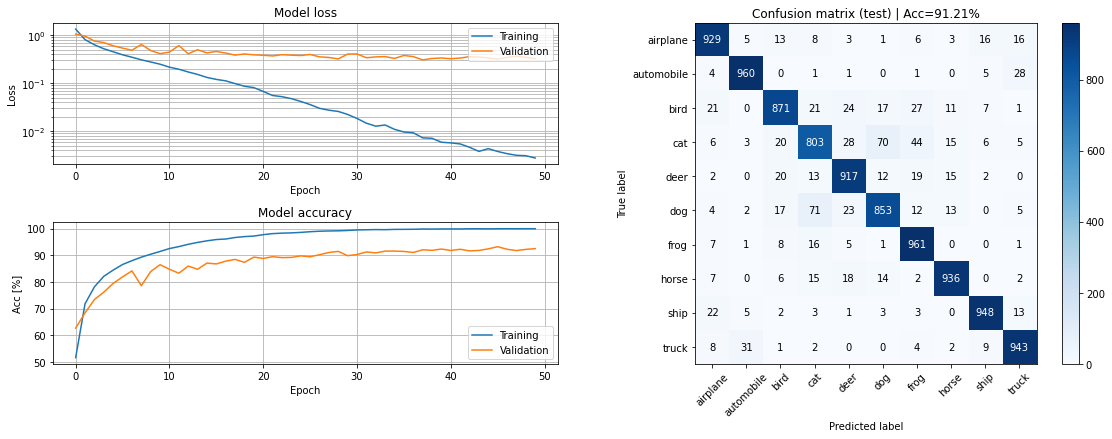

In [10]:
PlotModelEval(model, history, X_test, y_test, cifar_labels)

In [11]:
model.save("CompetionModel_" + GroupName + "_50.h5")